
# Predicting Customer Satisfaction on Rent the Runway

##  V. Modeling Classification using Non-Neural Models

### Katrin Ayrapetov


<font style="font-size: 2rem; color: blue">


 
</font>

### Overview of the Notebook: 

**Feature Variables:** Type_of_Customer, Size, Overall_fit, Rented_for,Size_usually_worn, Height, Age, Bust_size, Body_type,
Weight, Date, Brand, Rent_price, Number_of_reviews,
       BMI, Sleeves, Neckline, Dress_Style, kfold, Height_binned,
       Age_binned, Weight_binned, Rent_price_binned,
       Number_of_reviews_binned, BMI_binned


**Target Variable:**
1: Not Satisfied with Rental (Satisfaction Rating of 1,2,3 stars)   - 13% of observations 
0: Satisfied with Rental (Satisfaction Rating 4,5 stars)  - 87% of observations 



#### Logistic Regression 
<br>&emsp;&emsp;**Accuracy** - 0.836 
<br>&emsp;&emsp;**ROC AUC** - 0.535

#### Naive Bayes Classifier 
<br>&emsp;&emsp;**Accuracy** - 0.803
<br>&emsp;&emsp;**ROC AUC** - 0.629

#### Knn Classifier 
<br>&emsp;&emsp;**Accuracy** - 0.834
<br>&emsp;&emsp;**ROC AUC** - 0.5320

#### Random Classifier 
<br>&emsp;&emsp;**Accuracy** - 0.8695
<br>&emsp;&emsp;**ROC AUC** - 0.6642

#### XGBoost  
<br>&emsp;&emsp;**Accuracy** - 0.8698
<br>&emsp;&emsp;**ROC AUC** - 0.6638




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, plot_confusion_matrix, plot_roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier
from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools
import statsmodels.api as sm
import time
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn import model_selection

In [3]:
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)

In [7]:
df =  pd.read_csv('../Data/df_clean_final.csv')

In [8]:
#Binarize the Predictor Variable: Satisfaction Rating 
# 1: Not Satisfied with Rental (Satisfaction Rating of 1,2,3) 
# 0: Satisfied with Rental (Satisfaction Rating 4,5)
df['Rating'] = np.where(df['Rating'] <= 3, 1, 0)

In [6]:
df.columns

Index(['Type_of_Customer', 'Size', 'Overall_fit', 'Rented_for',
       'Size_usually_worn', 'Height', 'Age', 'Bust_size', 'Body_type',
       'Weight', 'Rating', 'Date', 'Brand_x', 'Dress_Description', 'Band_Size',
       'Cup_Size', 'BMI', 'Brand_y', 'Retail_price', 'Rent_price',
       'Number_of_reviews', 'cotton', 'nylon', 'cellulose', 'silk', 'spandex',
       'tencel', 'rayon', 'linen', 'cashmere', 'wool', 'leather', 'polyester',
       'metallic_fibers', 'Length', 'Sleeves', 'Neckline'],
      dtype='object')

In [9]:
#Drop Unnecessary Columns 
df.dropna(inplace=True)
df = df.reset_index()
df.drop(columns="index",inplace=True)

In [10]:
#Create a target variable vector. 
y = df.Rating.values

In [11]:
#Because the target class is unbalanced, use the k-fold method to create 5 k-folds. 

#initiate the kfold class from model_selection module
#The folds are made by preserving the percentage of samples for each class.
kf = model_selection.StratifiedKFold(n_splits=5)

#Create a column to hold kfold labels 
df["kfold"] = -1

#Reshuffle the rows. 
df = df.sample(frac=1).reset_index(drop=True)

for f, (t_,v_) in enumerate(kf.split(X=df,y=y)):
    df.loc[v_,"kfold"] = f

In [12]:
train = df[df.kfold != 3].reset_index(drop=True)
test = df[df.kfold == 3].reset_index(drop=True)

In [13]:
train.drop(columns=["kfold"],inplace=True)
test.drop(columns=["kfold"],inplace=True)

### Train Dataset

In [14]:
#Label Encode both Data Sets 
# For Train set
lencoders = {}
for col in train.select_dtypes(include=['object']).columns:
    lencoders[col] = LabelEncoder()
    train[col] = lencoders[col].fit_transform(train[col])
    
# For Test Set
lencoders_t = {}
for col in test.select_dtypes(include=['object']).columns:
    lencoders_t[col] = LabelEncoder()
    test[col] = lencoders_t[col].fit_transform(test[col])

In [15]:
df.columns

Index(['Type_of_Customer', 'Size', 'Overall_fit', 'Rented_for',
       'Size_usually_worn', 'Height', 'Age', 'Body_type', 'Weight', 'Rating',
       'Date', 'Brand_x', 'Band_Size', 'Cup_Size', 'BMI', 'Retail_price',
       'Rent_price', 'Number_of_reviews', 'cotton', 'nylon', 'cellulose',
       'silk', 'spandex', 'tencel', 'rayon', 'linen', 'cashmere', 'wool',
       'leather', 'polyester', 'metallic_fibers', 'Length', 'Sleeves',
       'Neckline', 'kfold'],
      dtype='object')

In [16]:
features = ['Type_of_Customer', 'Size', 'Overall_fit', 'Rented_for',
       'Size_usually_worn', 'Height', 'Age', 'Body_type', 'Weight',
       'Date', 'Brand_x', 'Band_Size', 'Cup_Size', 'BMI', 'Retail_price',
       'Rent_price', 'Number_of_reviews', 'cotton', 'nylon', 'cellulose',
       'silk', 'spandex', 'tencel', 'rayon', 'linen', 'cashmere', 'wool',
       'leather', 'polyester', 'metallic_fibers', 'Length', 'Sleeves',
       'Neckline']
target = ['Rating']

# Split into test and train
X_train = train[features]
y_train = train[target].to_numpy()
X_test = test[features]
y_test = test[target].to_numpy()

# Normalize Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [17]:
def run_model(model, X_train, y_train, X_test, y_test, verbose=True):
    t0=time.time()
    if verbose == False:
        model.fit(X_train,y_train.ravel(), verbose=0)
    else:
        model.fit(X_train,y_train.ravel())
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred) 
    time_taken = time.time()-t0
    print("Accuracy = {}".format(accuracy))
    print("ROC Area under Curve = {}".format(roc_auc))
    print("Time taken = {}".format(time_taken))
    print(classification_report(y_test,y_pred,digits=5))
    plot_confusion_matrix(model, X_test, y_test,cmap=plt.cm.pink, normalize = 'all')
    plot_roc_curve(model, X_test, y_test)                     
    
    return model, accuracy, roc_auc, time_taken

In [20]:
df["Rating"].value_counts(normalize=True)

0    0.83315
1    0.16685
Name: Rating, dtype: float64

#### Logistic Regression

Accuracy = 0.8318343234542498
ROC Area under Curve = 0.5187072092164347
Time taken = 8.217891931533813
              precision    recall  f1-score   support

           0    0.83722   0.99043   0.90740     25066
           1    0.49791   0.04699   0.08587      5065

    accuracy                        0.83183     30131
   macro avg    0.66756   0.51871   0.49664     30131
weighted avg    0.78018   0.83183   0.76930     30131



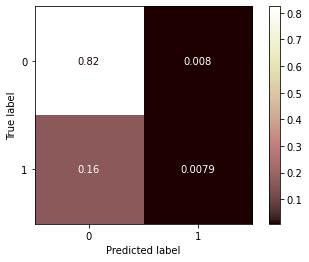

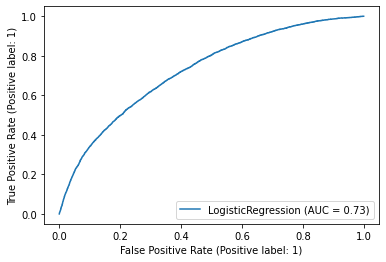

In [18]:
# Logistic Regression penalized with Elastic Net (L1 penalty = 50%, L2 penalty = 50%)

params_lr = {'penalty': 'elasticnet', 'l1_ratio':0.5, 'solver': 'saga'}

model_lr = LogisticRegression(**params_lr)
model_lr, accuracy_lr, roc_auc_lr, tt_lr = run_model(model_lr, X_train, y_train, X_test, y_test)

#### Naive Bayes Classifier

Accuracy = 0.7348245992499419
ROC Area under Curve = 0.612504740692863
Time taken = 0.12041544914245605
              precision    recall  f1-score   support

           0    0.87336   0.79678   0.83331     25066
           1    0.29864   0.42823   0.35188      5065

    accuracy                        0.73482     30131
   macro avg    0.58600   0.61250   0.59260     30131
weighted avg    0.77675   0.73482   0.75238     30131



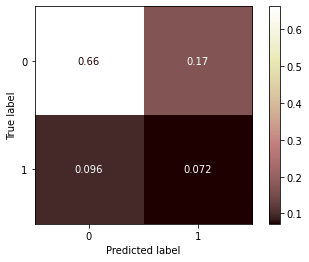

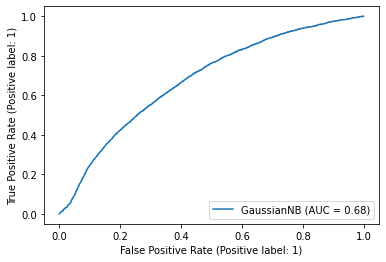

In [21]:
params_nb = {}

model_nb = GaussianNB(**params_nb)
model_nb, accuracy_nb, roc_auc_nb, tt_nb = run_model(model_nb, X_train, y_train, X_test, y_test)

#### Random Forest

Accuracy = 0.8626331684975607
ROC Area under Curve = 0.6267003147229321
Time taken = 16.121769189834595
              precision    recall  f1-score   support

           0    0.86962   0.98213   0.92245     25066
           1    0.75412   0.27127   0.39901      5065

    accuracy                        0.86263     30131
   macro avg    0.81187   0.62670   0.66073     30131
weighted avg    0.85020   0.86263   0.83446     30131



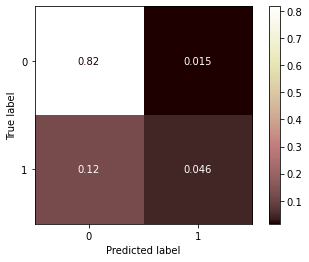

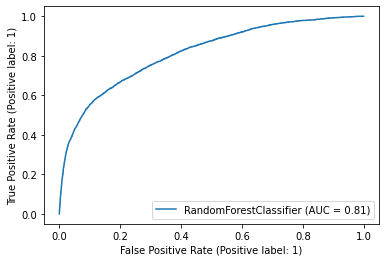

In [23]:
params_rf = {'max_depth': 16,
             'min_samples_leaf': 1,
             'min_samples_split': 2,
             'n_estimators': 100,
             'random_state': 12345}

model_rf = RandomForestClassifier(**params_rf)
model_rf, accuracy_rf, roc_auc_rf, tt_rf = run_model(model_rf, X_train, y_train, X_test, y_test)

#### XGBoost

Accuracy = 0.8594138926686801
ROC Area under Curve = 0.614525408105228
Time taken = 2.7641823291778564
              precision    recall  f1-score   support

           0    0.86580   0.98344   0.92088     25066
           1    0.74985   0.24561   0.37002      5065

    accuracy                        0.85941     30131
   macro avg    0.80782   0.61453   0.64545     30131
weighted avg    0.84631   0.85941   0.82828     30131



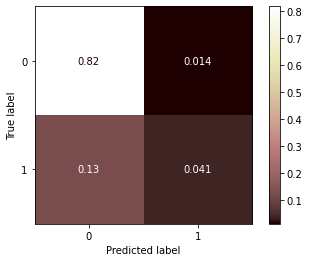

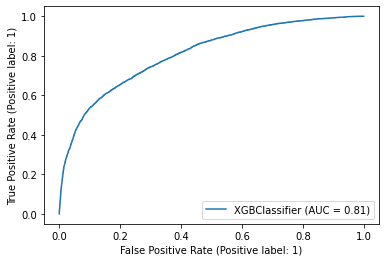

In [24]:
model_xgb = xgb.XGBClassifier(random_state=42,
                          use_label_encoder=False,
                          colsample_bytree=0.5,
                          learning_rate=0.1,
                          max_depth=3,
                          n_estimators=200,
                          subsample=1)


model_xgb, accuracy_xgb, roc_auc_xgb, tt_xgb = run_model(model_xgb, X_train, y_train, X_test, y_test)

### Model Comparison

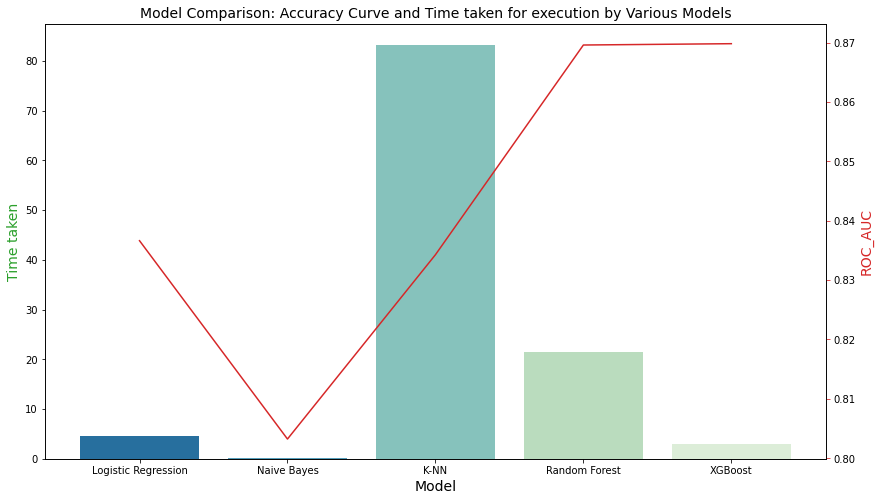

In [32]:
acc_scores = [accuracy_lr, accuracy_nb, accuracy_kn,   accuracy_rf, accuracy_xgb]
tt = [tt_lr, tt_nb, tt_kn,  tt_rf, tt_xgb]

model_data = {'Model': ['Logistic Regression','Naive Bayes','K-NN','Random Forest',"XGBoost"],
              'Accuracy': acc_scores,
              'Time taken': tt}
data = pd.DataFrame(model_data)

fig, ax1 = plt.subplots(figsize=(14,8))
ax1.set_title('Model Comparison: Accuracy Curve and Time taken for execution by Various Models', fontsize=14)
color = 'tab:green'
ax1.set_xlabel('Model', fontsize=14)
ax1.set_ylabel('Time taken', fontsize=14, color=color)
ax2 = sns.barplot(x='Model', y='Time taken', data = data, palette='GnBu_r')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('ROC_AUC', fontsize=14, color=color)
ax2 = sns.lineplot(x='Model', y='Accuracy', data = data, sort=False, color=color)
ax2.tick_params(axis='y', color=color)

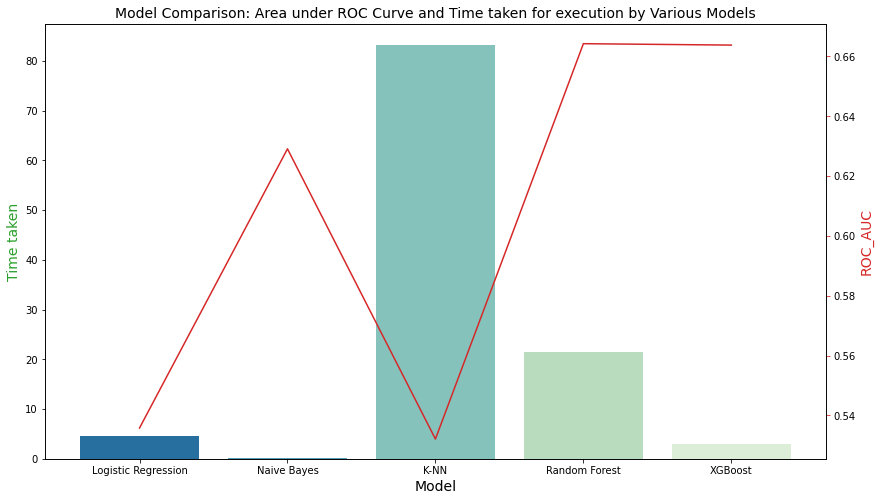

In [25]:
roc_auc_scores = [roc_auc_lr, roc_auc_nb, roc_auc_kn,   roc_auc_rf, roc_auc_xgb]
tt = [tt_lr, tt_nb, tt_kn,  tt_rf, tt_xgb]

model_data = {'Model': ['Logistic Regression','Naive Bayes','K-NN','Random Forest',"XGBoost"],
              'ROC_AUC': roc_auc_scores,
              'Time taken': tt}
data = pd.DataFrame(model_data)

fig, ax1 = plt.subplots(figsize=(14,8))
ax1.set_title('Model Comparison: Area under ROC Curve and Time taken for execution by Various Models', fontsize=14)
color = 'tab:green'
ax1.set_xlabel('Model', fontsize=14)
ax1.set_ylabel('Time taken', fontsize=14, color=color)
ax2 = sns.barplot(x='Model', y='Time taken', data = data, palette='GnBu_r')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('ROC_AUC', fontsize=14, color=color)
ax2 = sns.lineplot(x='Model', y='ROC_AUC', data = data, sort=False, color=color)
ax2.tick_params(axis='y', color=color)